<a href="https://colab.research.google.com/github/sruby8/uplift.ai/blob/master/Chart_Uplift_trunk_pelvis_arm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

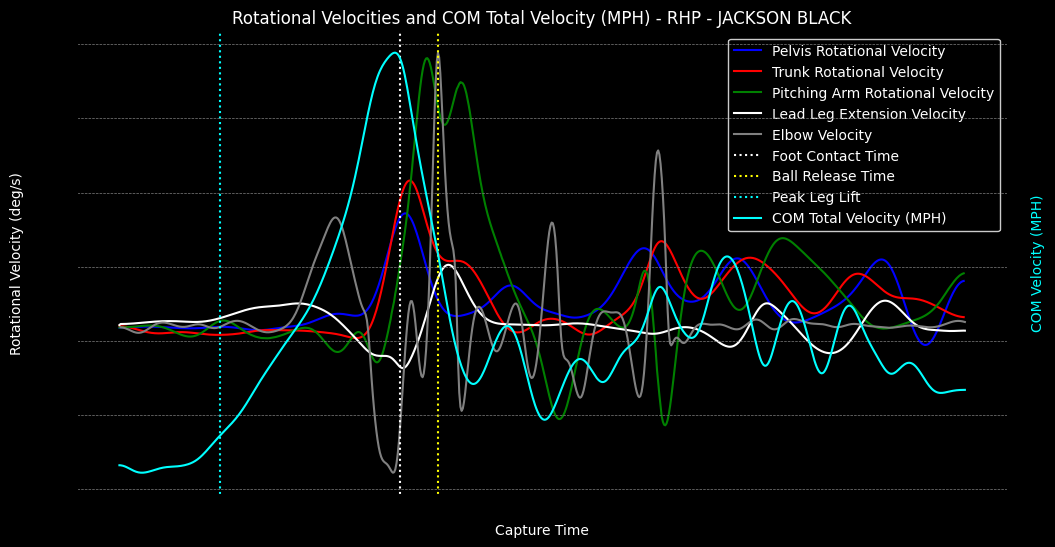

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
file_path = "/content/uplift_data_export_20250515033446.csv"
data = pd.read_csv(file_path)

# Define column names
athlete_name_col = "athlete_name"
handedness_col = "handedness"
trunk_velocity_col = "trunk_rotational_velocity_with_respect_to_ground"
pelvis_velocity_col = "pelvis_rotational_velocity_with_respect_to_ground"
left_arm_velocity_col = "left_arm_rotational_velocity_with_respect_to_ground"
right_arm_velocity_col = "right_arm_rotational_velocity_with_respect_to_ground"
left_elbow_velocity_col = "left_elbow_flexion_velocity"
right_elbow_velocity_col = "right_elbow_flexion_velocity"
right_knee_velocity_col = "right_knee_extension_velocity"
left_knee_velocity_col = "left_knee_extension_velocity"
foot_contact_time_col = "foot_contact_time"
ball_release_time_col = "ball_release_time"
time_col = "time"

# Extract athlete name and handedness
athlete_name_chart = data[athlete_name_col].iloc[0]
pitcher_handedness = data[handedness_col].iloc[0].lower()
pitcherhand = "LHP" if pitcher_handedness == "left" else "RHP"

# Selecting appropriate columns
arm_velocity_col = left_arm_velocity_col if pitcherhand == "LHP" else right_arm_velocity_col
elbow_velocity_col = left_elbow_velocity_col if pitcherhand == "LHP" else right_elbow_velocity_col
lead_leg_velocity_col = right_knee_velocity_col if pitcherhand == "LHP" else left_knee_velocity_col

# Creating a subset with necessary columns
subset_data = data[[time_col, trunk_velocity_col, pelvis_velocity_col, arm_velocity_col,
                    elbow_velocity_col, lead_leg_velocity_col, foot_contact_time_col, ball_release_time_col,
                    'whole_body_center_of_mass_x', 'whole_body_center_of_mass_y', 'whole_body_center_of_mass_z']].copy()

# Calculate WB COM Total Velocity (3D) using gradient
fps = data['fps'].iloc[0]
dt = 1 / fps
velocity_x = np.gradient(data['whole_body_center_of_mass_x'], dt)
velocity_y = np.gradient(data['whole_body_center_of_mass_y'], dt)
velocity_z = np.gradient(data['whole_body_center_of_mass_z'], dt)
com_velocity_mps = np.sqrt(velocity_x**2 + velocity_y**2 + velocity_z**2)
com_velocity_mph = com_velocity_mps * 2.23694
subset_data['wb_com_total_velocity_mph'] = com_velocity_mph

# Adjusting velocities for LHP normalization
if pitcherhand == "LHP":
    # Rename the columns instead of trying to access non-existent columns
    subset_data = subset_data.rename(columns={
        pelvis_velocity_col: "pelvis_velocity",
        trunk_velocity_col: "trunk_velocity",
        arm_velocity_col: "arm_velocity",
        lead_leg_velocity_col: "lead_leg_extension_velocity"
    })
    subset_data[["pelvis_velocity", "trunk_velocity", "arm_velocity", "lead_leg_extension_velocity"]] *= -1
else:
    # Rename columns for RHP as well
    subset_data = subset_data.rename(columns={
        pelvis_velocity_col: "pelvis_velocity",
        trunk_velocity_col: "trunk_velocity",
        arm_velocity_col: "arm_velocity",
        lead_leg_velocity_col: "lead_leg_extension_velocity"
    })

subset_data = subset_data.rename(columns={elbow_velocity_col: "elbow_velocity"}) # Rename for elbow velocity too
subset_data["elbow_velocity"] *= -1 # This line remains the same

# Identifying marker times
foot_contact_time = subset_data.loc[subset_data["foot_contact_time"] == 0.0, "time"].min()
ball_release_time = subset_data.loc[subset_data["ball_release_time"] == 0.0, "time"].min()
peak_leg_lift_frame = data.loc[data['max_knee_raise_frame'] == 0, "time"].min()

# Plotting the 2D chart with dual Y-axes
fig, ax1 = plt.subplots(figsize=(12, 6), facecolor="black")
ax1.set_facecolor("black")

# Plotting the rotational velocities on the left Y-axis
ax1.plot(subset_data["time"], subset_data["pelvis_velocity"], color="blue", label="Pelvis Rotational Velocity")
ax1.plot(subset_data["time"], subset_data["trunk_velocity"], color="red", label="Trunk Rotational Velocity")
ax1.plot(subset_data["time"], subset_data["arm_velocity"], color="green", label="Pitching Arm Rotational Velocity")
ax1.plot(subset_data["time"], subset_data["lead_leg_extension_velocity"], color="white", label="Lead Leg Extension Velocity")
ax1.plot(subset_data["time"], subset_data["elbow_velocity"], color="gray", label="Elbow Velocity")

ax1.set_xlabel("Capture Time", color="white")
ax1.set_ylabel("Rotational Velocity (deg/s)", color="white")

# Creating a secondary Y-axis for WB COM Total Velocity
ax2 = ax1.twinx()
ax2.plot(subset_data["time"], subset_data["wb_com_total_velocity_mph"], color="cyan", label="COM Total Velocity (MPH)")
ax2.set_ylabel("COM Velocity (MPH)", color="cyan")

# Adding markers for events
if pd.notna(foot_contact_time):
    ax1.axvline(x=foot_contact_time, color="white", linestyle="dotted", label="Foot Contact Time")
if pd.notna(ball_release_time):
    ax1.axvline(x=ball_release_time, color="yellow", linestyle="dotted", label="Ball Release Time")
if pd.notna(peak_leg_lift_frame):
    ax1.axvline(x=peak_leg_lift_frame, color="cyan", linestyle="dotted", label="Peak Leg Lift")

# Combining legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, facecolor="black", edgecolor="white", labelcolor="white")

# Customizing the chart
plt.title(f"Rotational Velocities and COM Total Velocity (MPH) - {pitcherhand} - {athlete_name_chart}", color="white")
plt.grid(color="gray", linestyle="--", linewidth=0.5)
plt.show()

